# A basic Demonstration of MetaCast

MetaCast has been developed from the codebase used in Grunnill et al. (2024). MetaCast's main feature is broad*CAST*ing epidemiological and ecological subpopulation models over multiple dimensions (axis) to form a *META*population model.

This notebook uses a disease X SEIHR (Susceptible - Exposed - Infected - Hospitalised - Recovered) subpopulation model as a motivating example. In possible scenarios in outbreak of disease X that epidemiological modellers my wish to simulate:
1. Risk-Structured: Single Dimension/Axis disease X model.
2. Seeding at 10% prevalence: Multinomial seeder
3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.
4. New Vaccine: Multi Dimension/Axis disease X model with flows between some subpopulations.
5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.


# 1. Risk-Structured: Single Dimension/Axis disease X model.

Import MetaCast's main class MetaCaster.

In [1]:
from metacast import MetaCaster

## 1.1 MetaCaster setup
### 1.1.1 Define subpopulation model.

This is the function that is your subpopulation model that MetaCaster will broadcast across the metapopulation generated by your scaffold (see 1.2).
The arguments are required

In [2]:
def subpop_model(y, y_deltas, parameters, states_index, subpop_suffix, foi):
    """
    Calculate derivatives of variables in disease X's subpopulation model

    Parameters
    ----------
    y : numpy.Array
        An array of the state variables at this time.
    y_deltas : numpy.Array
        The derivatives of y at this time.
    parameters : dict {str:Number or callable}
        A dictionary of parameter values.
    states_index : dict {str:int}

    subpop_suffix : str

    foi : float
        Force of infection experienced be susceptible hosts in this subpopulation.

    Returns
    -------
    y_deltas : numpy.Array
        y_deltas with derivatives of variables in disease X's subpopulation model added to.

    """
    infections = foi * y[states_index['S']]
    progression_from_exposed = parameters['sigma'] * y[states_index['E']]
    probability_of_hospitalisation = parameters['p' + subpop_suffix] # this is our subpopulation specific parameter
    progression_from_infectious = y[states_index['I']]*parameters['gamma']
    recovery = progression_from_infectious*(1-probability_of_hospitalisation)
    hospitalisation = progression_from_infectious*probability_of_hospitalisation
    hospital_recovery = y[states_index['H']]*parameters['eta']


    # Updating y_deltas with derivative calculations from this subpopulation.
    y_deltas[states_index['S']] += - infections
    y_deltas[states_index['E']] += infections - progression_from_exposed
    y_deltas[states_index['I']] += progression_from_exposed - progression_from_infectious
    y_deltas[states_index['H']] += hospitalisation - hospital_recovery
    y_deltas[states_index['R']] += recovery+hospital_recovery
    y_deltas[-2] += hospitalisation - hospital_recovery
    y_deltas[-1] += hospitalisation

    return y_deltas

### 1.1.2 Define metapopulation scaffold.

In this first we are assuming structure comes from just the risk of hospitalisation (low and high). Simulations are going to be over 90 days. Therefore, we will assume no flows of population between subpopulations. As we are dealing with a one dimension axis metapopulation we can provide a set of strings as our scaffold (a list/tuple of unique strings is also acceptable. **Note** if dealing with a multidimensional metapopulation the scaffold would have to be a list/tuple of sets of strings.

In [3]:
risk_groups = ['low', 'high']

### 1.1.3 Define model attributes

In [4]:
model_attributes = {'states': ['S', 'E', 'I', 'H', 'R'],
                    'infected_states': ['E', 'I'],
                    'infectious_states': ['I'],
                    'symptomatic_states': ['I'],
                    'observed_states': ['H','H_cumulative'],
                    'universal_params': ['sigma', 'gamma', 'eta'],
                    'subpop_params': ['p']}

### 1.1.3 Intialise MetaCaster.

In [5]:
metapop_model = MetaCaster(scaffold=risk_groups, model_attributes=model_attributes, subpop_model=subpop_model)

# 1.2 Running model
## 1.2.1 Setting population

In [6]:
import numpy as np
metapop_model.num_states

12

In [7]:
state_index_dict_high = metapop_model.state_index['high']
state_index_dict_low = metapop_model.state_index['low']
display(state_index_dict_low, state_index_dict_high)

{'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9}

{'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4}

In [8]:
N = 1e6
proportion_high_risk = 0.1
low_risk_population = N*(1-proportion_high_risk)
high_risk_population = N*proportion_high_risk
y = np.zeros(metapop_model.num_states)
y[state_index_dict_low['S']] = low_risk_population-1
y[state_index_dict_low['I']] = 1
y[state_index_dict_high['S']] = high_risk_population
y

array([1.00000e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       8.99999e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00])

### 1.2.2 Setting up parameters

In [9]:
metapop_model.parameter_names

['beta_[high]',
 'beta_[low]',
 'eta',
 'gamma',
 'p_[high]',
 'p_[low]',
 'rho_[high]_[high]',
 'rho_[high]_[low]',
 'rho_[low]_[high]',
 'rho_[low]_[low]',
 'sigma']

In [10]:
non_subpop_parameters = {'eta': 1/5, 'gamma': 1/7,  'sigma': 1/3}
p_high = 0.3
p_high = 0.01
hospitalisation_probs = {'p_[high]': p_high, 'p_[low]': p_high}
beta = (2/7)/N
beta_parameters = {'beta'+ subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
rho = 1
interaction_parameters = {'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                          for subpop_suffix_i in metapop_model.subpop_suffixes
                          for subpop_suffix_j in metapop_model.subpop_suffixes}
parameters = {**non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'p_[high]': 0.01,
 'p_[low]': 0.01,
 'beta_[high]': 2.857142857142857e-07,
 'beta_[low]': 2.857142857142857e-07,
 'rho_[high]_[high]': 1,
 'rho_[high]_[low]': 1,
 'rho_[low]_[high]': 1,
 'rho_[low]_[low]': 1}

### 1.2.3 Run metapopulation model

In [11]:
#set time
end_day = 90
time_step = 1
t = np.arange(0, end_day+time_step, time_step)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [12]:
results_1 = metapop_model.integrate(y,t)
results_1

high                                                         low  \
                S          E           I         H           R              S   
0   100000.000000   0.000000    0.000000  0.000000    0.000000  899999.000000   
1    99999.972985   0.022911    0.003908  0.000002    0.000194  899998.756863   
2    99999.947570   0.038014    0.013053  0.000012    0.001351  899998.528128   
3    99999.922182   0.048841    0.024924  0.000035    0.004018  899998.299639   
4    99999.895846   0.057424    0.038181  0.000069    0.008480  899998.062612   
..            ...        ...         ...       ...         ...            ...   
86   99679.171312  64.975344   95.280960  0.478354  160.094031  897111.545018   
87   99650.860927  70.688384  103.675520  0.520550  174.254618  896856.751838   
88   99620.066034  76.899683  112.805318  0.566452  189.662513  896579.598102   
89   99586.570815  83.651946  122.733948  0.616382  206.426908  896278.141473   
90   99550.141119  90.991403  133.530356  0.670689  224.666432  895950.274569   

                                                   observed_states  \
             E            I         H            R               H   
0     0.000000     1.000000  0.000000     0.000000        0.000000   
1     0.206203     0.902053  0.001220     0.133660        0.001222   
2     0.342128     0.868956  0.002140     0.258649        0.002152   
3     0.439570     0.875754  0.002878     0.382159        0.002913   
4     0.516814     0.908351  0.003510     0.508713        0.003579   
..         ...          ...       ...          ...             ...   
86  584.777444   857.527688  4.305178  1441.844671        4.783532   
87  636.194751   933.078650  4.684948  1569.289813        5.205498   
88  692.096376  1015.246741  5.098066  1707.960715        5.664518   
89  752.866680  1104.604306  5.547433  1858.840108        6.163815   
90  818.921720  1201.771874  6.036197  2022.995640        6.706887   

                 
   H_cumulative  
0      0.000000  
1      0.001351  
2      0.002622  
3      0.003891  
4      0.005208  
..          ...  
86    16.067222  
87    17.487499  
88    19.032877  
89    20.714308  
90    22.543690  

[91 rows x 12 columns]

### 1.2.4 Plotting hospitalisations

In [13]:
import seaborn as sns
import pandas as pd

In [14]:
def unstack_results_and_plot_hospitalised(results):
    results_unstacked = results.unstack()
    results_unstacked = results_unstacked.reset_index()
    results_unstacked.columns = ['Subpopulation', 'State','t', 'value']
    hospitalised_results = results_unstacked[results_unstacked['State']=='H']
    sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')
    return results_unstacked

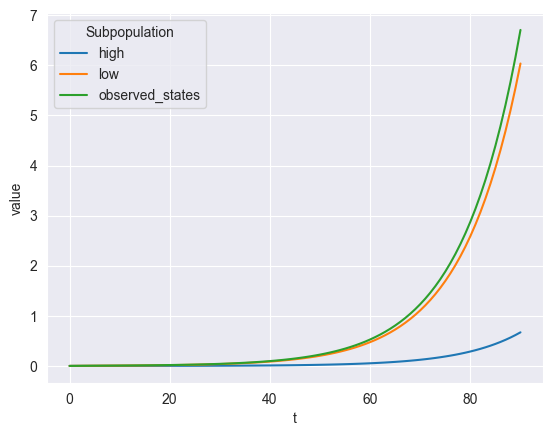

In [15]:
results_1_unstacked = unstack_results_and_plot_hospitalised(results_1)

In [16]:
# Total Hospitalised
display({'Total hospitalisations': results_1.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_1.loc[:,('observed_states','H')])})

{'Total hospitalisations': 22.543689586356805,
 'Peak hospitalisations': 6.706886521172006}

# 2.
## 2.1 Set up Seeders

In [17]:
from metacast import MultnomialSeeder

In [18]:
seeding_info = {'unhospitalised': {'E': 'sigma','I':'gamma'},
                'hospitalised': {'E': 'sigma','I':'gamma', 'H':'eta'},
                }
seeder = MultnomialSeeder(seeding_info)
seeder.set_seed(42) # This class uses random number generation (rng) use set_seed function to set rng seed.

## 2.2 Setup Populations with seeder

In [19]:
prevelance = 0.1
low_risk_total_infected = low_risk_population*prevelance
low_risk_infected = seeder.seed_infections(n=low_risk_total_infected,
                                           branch_probability={'unhospitalised': 1- parameters['p_[low]'] ,'hospitalised': parameters['p_[low]']},
                                           parameters=parameters)
low_risk_infected

{'H': 283, 'E': 26655, 'I': 63062}

In [20]:
high_risk_total_infected = high_risk_population*prevelance
high_risk_infected = seeder.seed_infections(n=high_risk_total_infected,
                                            branch_probability={'unhospitalised': 1- parameters['p_[high]'] ,'hospitalised': parameters['p_[high]']},
                                            parameters=parameters)
high_risk_infected

{'H': 34, 'E': 3059, 'I': 6907}

In [21]:
y =np.zeros(metapop_model.num_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in state_index_dict_low.items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]

y

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00])

In [22]:
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in state_index_dict_high.items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([9.0000e+04, 3.0590e+03, 6.9070e+03, 3.4000e+01, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       3.1700e+02, 0.0000e+00])

### 2.3 Run metapopulation model

In [23]:
results_seeded = metapop_model.integrate(y,t)
results_seeded

high                                                     \
               S            E            I          H             R   
0   90000.000000  3059.000000  6907.000000  34.000000      0.000000   
1   88209.763741  3714.100687  7047.718851  36.852790    991.563932   
2   86406.845962  4195.210176  7343.017919  39.482638   2015.443304   
3   84561.999902  4576.077326  7731.120414  42.085203   3088.717155   
4   82660.706290  4897.202276  8175.610397  44.759227   4221.721809   
..           ...          ...          ...        ...           ...   
86  17377.132227    58.495220   299.944137   3.477161  82260.951255   
87  17362.811285    54.065712   277.471271   3.220000  82302.431732   
88  17349.574185    49.972138   256.668257   2.981488  82340.803933   
89  17337.338808    46.188952   237.413033   2.760323  82376.298883   
90  17326.029271    42.692559   219.592167   2.555289  82409.130713   

              low                                                         \
                S             E             I           H              R   
0   810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1   793887.873666  32799.224750  63978.311572  313.759796    9020.830215   
2   777661.613661  37307.138187  66397.793112  341.217172   18292.237867   
3   761057.999117  40862.433543  69731.030547  367.489326   27981.047466   
4   743946.356609  43843.909397  73626.556696  393.720207   38189.457090   
..            ...           ...           ...         ...            ...   
86  156394.190047    526.456976   2699.494309   31.294374  740348.564295   
87  156265.301568    486.591406   2497.238902   28.979937  740721.888187   
88  156146.167665    449.749241   2310.012111   26.833335  741067.237648   
89  156036.049274    415.700566   2136.715391   24.842862  741386.691906   
90  155934.263443    384.233033   1976.327849   22.997561  741682.178113   

   observed_states               
                 H H_cumulative  
0       317.000000     0.000000  
1       350.612586   100.460067  
2       380.699811   203.713810  
3       409.574529   311.623392  
4       438.479434   425.326583  
..             ...          ...  
86       34.771535  8223.272871  
87       32.199936  8227.395199  
88       29.814823  8231.208564  
89       27.603186  8234.735940  
90       25.552850  8237.998617  

[91 rows x 12 columns]

### 2.4 Plotting hospitalisations

,Subpopulation,State,t,value
0,high,S,0,90000.000000
1,high,S,1,88209.763741
2,high,S,2,86406.845962
3,high,S,3,84561.999902
4,high,S,4,82660.706290
...,...,...,...,...
1087,observed_states,H_cumulative,86,8223.272871
1088,observed_states,H_cumulative,87,8227.395199
1089,observed_states,H_cumulative,88,8231.208564
1090,observed_states,H_cumulative,89,8234.735940


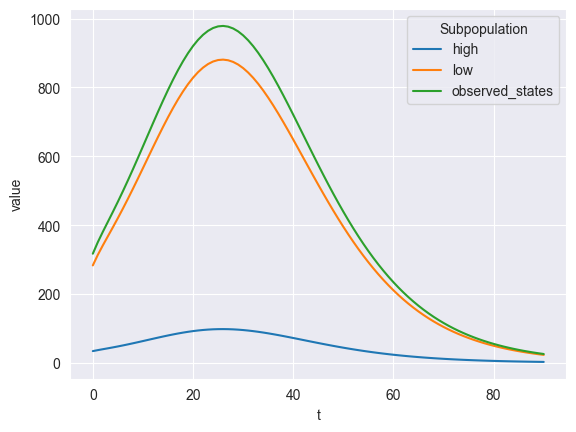

In [24]:
unstack_results_and_plot_hospitalised(results_seeded)

In [25]:
display({'Total hospitalisations': results_seeded.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_seeded.loc[:,('observed_states','H')])})

{'Total hospitalisations': 8237.998616768276,
 'Peak hospitalisations': 978.8907619120494}

# 3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.

## 3.1 Change Population Structure

In [26]:
isolation_groups = ['negative','positive']
rapid_pathogen_test_scaffold = [risk_groups,isolation_groups]

In [27]:
metapop_model.set_structure(rapid_pathogen_test_scaffold)
metapop_model.subpops

[{'high', 'low'}, {'negative', 'positive'}]

## 3.2 Set Population

In [28]:
metapop_model.state_index

{('high', 'negative'): {'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4},
 ('high', 'positive'): {'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9},
 ('low', 'negative'): {'S': 10, 'E': 11, 'I': 12, 'H': 13, 'R': 14},
 ('low', 'positive'): {'S': 15, 'E': 16, 'I': 17, 'H': 18, 'R': 19},
 'observed_states': {'H': 20, 'H_cumulative': 21}}

In [29]:
y =np.zeros(metapop_model.num_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in metapop_model.state_index[('low', 'negative')].items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in metapop_model.state_index[('high', 'negative')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([9.0000e+04, 3.0590e+03, 6.9070e+03, 3.4000e+01, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.1700e+02, 0.0000e+00])

## 3.3 Set parameters

In [30]:
metapop_model.parameter_names

['beta_[high,negative]',
 'beta_[high,positive]',
 'beta_[low,negative]',
 'beta_[low,positive]',
 'eta',
 'gamma',
 'p_[high,negative]',
 'p_[high,positive]',
 'p_[low,negative]',
 'p_[low,positive]',
 'rho_[high,negative]_[high,negative]',
 'rho_[high,negative]_[high,positive]',
 'rho_[high,negative]_[low,negative]',
 'rho_[high,negative]_[low,positive]',
 'rho_[high,positive]_[high,negative]',
 'rho_[high,positive]_[high,positive]',
 'rho_[high,positive]_[low,negative]',
 'rho_[high,positive]_[low,positive]',
 'rho_[low,negative]_[high,negative]',
 'rho_[low,negative]_[high,positive]',
 'rho_[low,negative]_[low,negative]',
 'rho_[low,negative]_[low,positive]',
 'rho_[low,positive]_[high,negative]',
 'rho_[low,positive]_[high,positive]',
 'rho_[low,positive]_[low,negative]',
 'rho_[low,positive]_[low,positive]',
 'sigma']

In [31]:
beta_parameters = {'beta' + subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
isolation_hospitalisation_probs = {
    **{'p_[high,'+ isolation_group +']': hospitalisation_probs['p_[high]'] for isolation_group in isolation_groups},
    **{'p_[low,'+ isolation_group +']': hospitalisation_probs['p_[low]'] for isolation_group in isolation_groups}
}

In [32]:
transmission_reduction_from_isolation = 0.6
interaction_parameters = {
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',negative]': rho
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups},
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',positive]': rho*(1-transmission_reduction_from_isolation)
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups}
}
interaction_parameters

{'rho_[high,negative]_[low,negative]': 1,
 'rho_[high,negative]_[high,negative]': 1,
 'rho_[high,positive]_[low,negative]': 1,
 'rho_[high,positive]_[high,negative]': 1,
 'rho_[low,negative]_[low,negative]': 1,
 'rho_[low,negative]_[high,negative]': 1,
 'rho_[low,positive]_[low,negative]': 1,
 'rho_[low,positive]_[high,negative]': 1,
 'rho_[high,negative]_[low,positive]': 0.4,
 'rho_[high,negative]_[high,positive]': 0.4,
 'rho_[high,positive]_[low,positive]': 0.4,
 'rho_[high,positive]_[high,positive]': 0.4,
 'rho_[low,negative]_[low,positive]': 0.4,
 'rho_[low,negative]_[high,positive]': 0.4,
 'rho_[low,positive]_[low,positive]': 0.4,
 'rho_[low,positive]_[high,positive]': 0.4}

In [33]:
parameters = {**non_subpop_parameters,
              **isolation_hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters

## 3.4 Set up Event Que

Import EventQueue and TransferEvent

In [34]:
from metacast.event_handling import EventQueue, TransferEvent

In [35]:
from_index = [index
              for risk_group in risk_groups
              for state, index in metapop_model.state_index[(risk_group,'negative')].items()
              if state in ['E','I']]
to_index = [index
            for risk_group in risk_groups
            for state, index in metapop_model.state_index[(risk_group,'positive')].items()
            if state in ['E','I']]
display(from_index,to_index)

[11, 12, 1, 2]

[16, 17, 6, 7]

In [36]:
test_every_x_days = 7
complaince = 0.8
test_sensitivity = 0.6
rapid_pathogen_test_event = TransferEvent(name='Rapid pathogen test',
                                          times= range(0,end_day+time_step,test_every_x_days),
                                          proportion= test_sensitivity*complaince,
                                          from_index= from_index,
                                          to_index= to_index)


testing_eventqueue = EventQueue(rapid_pathogen_test_event)

## 3.5 Run simulations with Events

In [37]:
results_rapid_test, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                    run_attribute='integrate',
                                                                    parameters=parameters,
                                                                    parameters_attribute='parameters',
                                                                    y0=y,
                                                                    end_time=end_day,
                                                                    start_time=0,
                                                                    simulation_step=time_step)
results_rapid_test

high,negative                                                     \
               S            E            I          H             R   
0   90000.000000  1590.680000  3591.640000  34.000000      0.000000   
1   88721.645528  2226.928738  3714.206046  32.548366    520.991322   
2   87426.363762  2697.897962  3989.638604  31.629071   1070.790601   
3   86091.940562  3069.031803  4357.544190  31.299883   1666.503562   
4   84706.063335  3378.924709  4781.263568  31.547104   2318.521283   
..           ...          ...          ...        ...           ...   
86  39930.119905    90.388898   161.848385   1.880656  28157.226620   
87  39895.794077    93.936448   168.996718   1.754074  28180.983145   
88  39862.320343    95.755350   176.003903   1.659659  28205.725208   
89  39829.641425    96.383862   182.442508   1.591084  28231.405585   
90  39797.716110    96.194171   188.081174   1.542758  28257.930250   

   high,positive                                                     ...  \
               S            E            I          H             R  ...   
0            0.0  1468.320000  3315.360000   0.000000      0.000000  ...   
1            0.0  1052.097255  3260.336894   4.269900    466.975952  ...   
2            0.0   753.860624  3103.127660   7.620403    919.071313  ...   
3            0.0   540.164739  2888.378445  10.117610   1345.019206  ...   
4            0.0   387.044946  2645.992315  11.863016   1738.779723  ...   
..           ...          ...          ...        ...           ...  ...   
86           0.0    41.390394   357.450282   3.265620  31256.429241  ...   
87           0.0    29.657513   320.755833   3.111791  31305.010400  ...   
88           0.0    21.250537   285.859228   2.939447  31348.486325  ...   
89           0.0    15.226675   253.396203   2.754740  31387.157920  ...   
90           0.0    10.910389   223.669806   2.563294  31421.392048  ...   

    low,negative                            low,positive                \
               I           H              R            S             E   
0   32792.240000  283.000000       0.000000          0.0  12794.400000   
1   33713.252208  274.580544    4737.233193          0.0   9167.588210   
2   36068.275991  269.915485    9713.164774          0.0   6568.863982   
3   39296.390054  269.775768   15088.499334          0.0   4706.796704   
4   43055.324932  274.224670   20961.471763          0.0   3372.567192   
..           ...         ...            ...          ...           ...   
86   1456.635464   16.925900  253459.239369          0.0    372.513545   
87   1520.970461   15.786667  253673.048096          0.0    266.917615   
88   1584.035126   14.936928  253895.726662          0.0    191.254829   
89   1641.982568   14.319757  254126.850048          0.0    137.040072   
90   1692.730563   13.884825  254365.572033          0.0     98.193501   

                                            observed_states               
               I           H              R               H H_cumulative  
0   30269.760000    0.000000       0.000000      317.000000     0.000000  
1   29606.476159   38.868535    4251.227096      350.267346   100.096949  
2   28077.252226   69.203207    8348.840585      378.368166   201.132354  
3   26067.860481   91.704169   12197.798647      402.897429   303.837182  
4   23836.041129  107.353574   15748.198105      424.988365   408.749592  
..           ...         ...            ...             ...          ...  
86   3217.049609   29.390508  281263.666384       51.462684  5938.710243  
87   2886.799960   28.006058  281700.896413       48.658590  5945.915966  
88   2572.730854   26.454968  282092.179395       45.991001  5952.711086  
89   2280.563917   24.792613  282440.223445       43.458194  5959.120952  
90   2013.026599   23.069606  282748.330341       41.060483  5965.172852  

[91 rows x 22 columns]

In [38]:
transfer_df

,time,transfered,event
0,0,47847.840000,Rapid pathogen test
1,7,49515.192799,Rapid pathogen test
2,14,48539.402471,Rapid pathogen test
3,21,43867.106776,Rapid pathogen test
4,28,36416.624320,Rapid pathogen test
5,35,28173.405789,Rapid pathogen test
6,42,20684.232034,Rapid pathogen test
7,49,14645.148812,Rapid pathogen test
8,56,10123.779257,Rapid pathogen test
9,63,6891.525776,Rapid pathogen test


### 3.6 Plotting hospitalisations

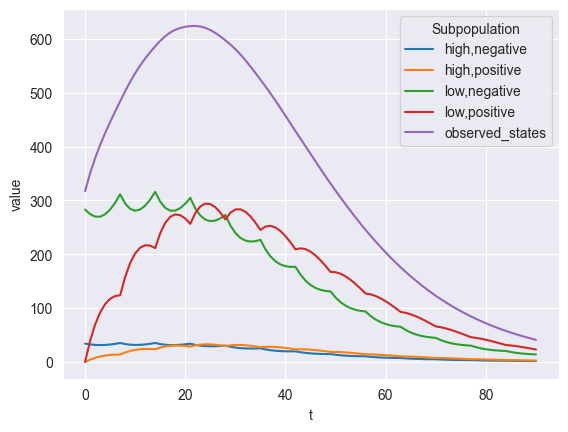

In [39]:
results_rapid_test_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test)

In [40]:
display({'Total hospitalisations': results_rapid_test.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_rapid_test.loc[:,('observed_states','H')])})

{'Total hospitalisations': 5965.172851548797,
 'Peak hospitalisations': 624.1063935585911}

## 3.6 Comparing with Rapid test event turned to null (do nothing) event.

In [41]:
metapop_model.state_index

{('high', 'negative'): {'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4},
 ('high', 'positive'): {'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9},
 ('low', 'negative'): {'S': 10, 'E': 11, 'I': 12, 'H': 13, 'R': 14},
 ('low', 'positive'): {'S': 15, 'E': 16, 'I': 17, 'H': 18, 'R': 19},
 'observed_states': {'H': 20, 'H_cumulative': 21}}

In [42]:
rapid_pathogen_test_event.make_event_a_nullevent()
results_rapid_test_null, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                         run_attribute='integrate',
                                                                         parameters=parameters,
                                                                         parameters_attribute='parameters',
                                                                         y0=y,
                                                                         end_time=end_day,
                                                                         start_time=0,
                                                                         simulation_step=time_step)
results_rapid_test_null

high,negative                                                     \
               S            E            I          H             R   
0   90000.000000  3059.000000  6907.000000  34.000000      0.000000   
1   88209.763741  3714.100687  7047.718851  36.852790    991.563932   
2   86406.845962  4195.210176  7343.017919  39.482638   2015.443304   
3   84561.999902  4576.077326  7731.120414  42.085203   3088.717155   
4   82660.706290  4897.202276  8175.610397  44.759227   4221.721809   
..           ...          ...          ...        ...           ...   
86  17377.132814    58.495234   299.944205   3.477161  82260.950585   
87  17362.811866    54.065725   277.471332   3.220001  82302.431075   
88  17349.574763    49.972151   256.668314   2.981488  82340.803284   
89  17337.339383    46.188964   237.413087   2.760324  82376.298243   
90  17326.029842    42.692570   219.592216   2.555290  82409.130082   

   high,positive                      ...  low,negative              \
               S    E    I    H    R  ...             I           H   
0            0.0  0.0  0.0  0.0  0.0  ...  63062.000000  283.000000   
1            0.0  0.0  0.0  0.0  0.0  ...  63978.311572  313.759796   
2            0.0  0.0  0.0  0.0  0.0  ...  66397.793112  341.217172   
3            0.0  0.0  0.0  0.0  0.0  ...  69731.030547  367.489326   
4            0.0  0.0  0.0  0.0  0.0  ...  73626.556696  393.720207   
..           ...  ...  ...  ...  ...  ...           ...         ...   
86           0.0  0.0  0.0  0.0  0.0  ...   2699.494918   31.294381   
87           0.0  0.0  0.0  0.0  0.0  ...   2497.239453   28.979943   
88           0.0  0.0  0.0  0.0  0.0  ...   2310.012630   26.833341   
89           0.0  0.0  0.0  0.0  0.0  ...   2136.715872   24.842868   
90           0.0  0.0  0.0  0.0  0.0  ...   1976.328293   22.997566   

                  low,positive                     observed_states  \
                R            S    E    I    H    R               H   
0        0.000000          0.0  0.0  0.0  0.0  0.0      317.000000   
1     9020.830215          0.0  0.0  0.0  0.0  0.0      350.612586   
2    18292.237867          0.0  0.0  0.0  0.0  0.0      380.699811   
3    27981.047466          0.0  0.0  0.0  0.0  0.0      409.574529   
4    38189.457090          0.0  0.0  0.0  0.0  0.0      438.479434   
..            ...          ...  ...  ...  ...  ...             ...   
86  740348.558265          0.0  0.0  0.0  0.0  0.0       34.771542   
87  740721.882280          0.0  0.0  0.0  0.0  0.0       32.199943   
88  741067.231806          0.0  0.0  0.0  0.0  0.0       29.814830   
89  741386.686145          0.0  0.0  0.0  0.0  0.0       27.603192   
90  741682.172429          0.0  0.0  0.0  0.0  0.0       25.552856   

                 
   H_cumulative  
0      0.000000  
1    100.460067  
2    203.713810  
3    311.623392  
4    425.326583  
..          ...  
86  8223.272804  
87  8227.395133  
88  8231.208499  
89  8234.735876  
90  8237.998554  

[91 rows x 22 columns]

In [43]:
transfer_df

,time,transfered,event
0,0,None,Rapid pathogen test
1,7,None,Rapid pathogen test
2,14,None,Rapid pathogen test
3,21,None,Rapid pathogen test
4,28,None,Rapid pathogen test
5,35,None,Rapid pathogen test
6,42,None,Rapid pathogen test
7,49,None,Rapid pathogen test
8,56,None,Rapid pathogen test
9,63,None,Rapid pathogen test


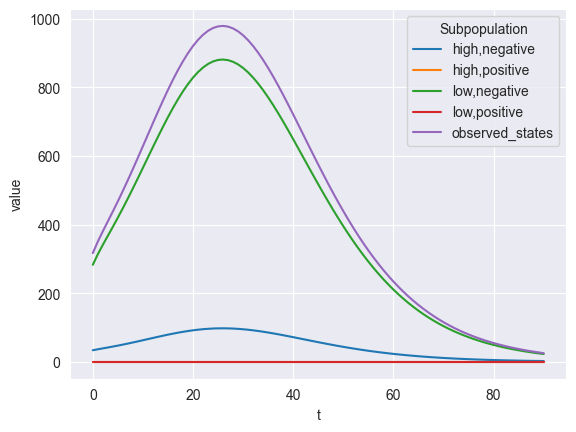

In [44]:
results_rapid_test_null_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test_null)

In [45]:
display({'Total hospitalisations': results_rapid_test_null.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_rapid_test_null.loc[:,('observed_states','H')])})

{'Total hospitalisations': 8237.998553665699,
 'Peak hospitalisations': 978.8907449881455}

# 4. Two New Vaccines of known efficacy: Multi Dimension/Axis disease X model with flows between subpopulations.

## 4.1 Set metapopulation structure using a list of subpopulation transfer dictionaries for a scaffold.

In [46]:
vaccination_groups = ['unvaccinated','vaccination_lag' 'vaccinated']
vaccination_transfers = [{'from_coordinates': (risk_group,'unvaccinated'),
                          'to_coordinates': (risk_group,'vaccination_lag'),
                          'states': ['S'], 'parameter': 'nu_0'}
                         for risk_group in risk_groups]
vacination_lag_transfers = [{'from_coordinates': (risk_group,'vaccination_lag'),
                             'to_coordinates': (risk_group,'vaccinated'),
                             'states': 'all', 'parameter': 'nu_1'}
                            for risk_group in risk_groups]

vaccination_scaffold = vaccination_transfers + vacination_lag_transfers
vaccination_scaffold

[{'from_coordinates': ('low', 'unvaccinated'),
  'to_coordinates': ('low', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('high', 'unvaccinated'),
  'to_coordinates': ('high', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('low', 'vaccination_lag'),
  'to_coordinates': ('low', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'},
 {'from_coordinates': ('high', 'vaccination_lag'),
  'to_coordinates': ('high', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'}]

In [47]:
metapop_model.set_structure(vaccination_scaffold)
metapop_model.subpops

[{'high', 'low'}, {'unvaccinated', 'vaccinated', 'vaccination_lag'}]

## 4.2 Set population

In [48]:
metapop_model.num_states

32

In [49]:
y = np.zeros(metapop_model.num_states)

for state, index in metapop_model.state_index[('high','unvaccinated')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

for state, index in metapop_model.state_index[('low','unvaccinated')].items():
    if state in low_risk_state_pops:
        y[index] =low_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       9.0000e+04, 3.0590e+03, 6.9070e+03, 3.4000e+01, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       3.1700e+02, 0.0000e+00])

## 4.3 Set parameters

In [50]:
metapop_model.parameter_names

['beta_[high,unvaccinated]',
 'beta_[high,vaccinated]',
 'beta_[high,vaccination_lag]',
 'beta_[low,unvaccinated]',
 'beta_[low,vaccinated]',
 'beta_[low,vaccination_lag]',
 'eta',
 'gamma',
 'nu_0',
 'nu_1',
 'p_[high,unvaccinated]',
 'p_[high,vaccinated]',
 'p_[high,vaccination_lag]',
 'p_[low,unvaccinated]',
 'p_[low,vaccinated]',
 'p_[low,vaccination_lag]',
 'rho_[high,unvaccinated]_[high,unvaccinated]',
 'rho_[high,unvaccinated]_[high,vaccinated]',
 'rho_[high,unvaccinated]_[high,vaccination_lag]',
 'rho_[high,unvaccinated]_[low,unvaccinated]',
 'rho_[high,unvaccinated]_[low,vaccinated]',
 'rho_[high,unvaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccinated]_[high,unvaccinated]',
 'rho_[high,vaccinated]_[high,vaccinated]',
 'rho_[high,vaccinated]_[high,vaccination_lag]',
 'rho_[high,vaccinated]_[low,unvaccinated]',
 'rho_[high,vaccinated]_[low,vaccinated]',
 'rho_[high,vaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccination_lag]_[high,unvaccinated]',
 'rho_[high,vaccination

In [51]:
def vaccination_parameters_setup(nu_0,
                                 nu_1,
                                 l_v,
                                 h_v,
                                 other_parameters,
                                 metapop_model):
    parameters = {key: value for key, value in other_parameters.items() if key in metapop_model.parameter_names}
    parameters.update({'nu_0': nu_0,
                       'nu_1': nu_1})

    beta = other_parameters['beta']
    parameters.update({'beta_[high,unvaccinated]': beta,
                       'beta_[high,vaccinated]': beta*(1-l_v),
                       'beta_[high,vaccination_lag]': beta,
                       'beta_[low,unvaccinated]': beta,
                       'beta_[low,vaccinated]': beta*(1-l_v),
                       'beta_[low,vaccination_lag]': beta})

    vaccine_reduced_severity_given_reduced_susceptibility = 1-((1-h_v)/(1-l_v))
    p_high = other_parameters['p_[high]']
    p_low = other_parameters['p_[low]']
    parameters.update({'p_[high,unvaccinated]': p_high,
                       'p_[high,vaccinated]': p_high*vaccine_reduced_severity_given_reduced_susceptibility,
                       'p_[high,vaccination_lag]': p_high,
                       'p_[low,unvaccinated]': p_low,
                       'p_[low,vaccinated]': p_low*vaccine_reduced_severity_given_reduced_susceptibility,
                       'p_[low,vaccination_lag]': p_low})
    rho = other_parameters['rho']
    parameters.update({'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                       for subpop_suffix_i in metapop_model.subpop_suffixes
                       for subpop_suffix_j in metapop_model.subpop_suffixes})
    return parameters

In [52]:
v_day = end_day
prob_vaccinated_by_v_day = 0.95
def prob_over_many_days_to_prob_on_a_day(prob, many_days):
    return 1-(1-prob)**(1/many_days)
prob_vaccinated_per_day = prob_over_many_days_to_prob_on_a_day(prob_vaccinated_by_v_day ,v_day)
vaccination_lag = 1/14
vaccine_reduced_susceptibility = 0.8
vaccine_reduced_severity = 0.8
other_parameters = {'beta':beta, 'rho': rho, **non_subpop_parameters, **hospitalisation_probs}
parameters = vaccination_parameters_setup(nu_0=prob_vaccinated_per_day*complaince,
                                          nu_1=vaccination_lag,
                                          l_v=vaccine_reduced_susceptibility,
                                          h_v=vaccine_reduced_severity,
                                          other_parameters=other_parameters,
                                          metapop_model=metapop_model)
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'nu_0': 0.02619042706682766,
 'nu_1': 0.07142857142857142,
 'beta_[high,unvaccinated]': 2.857142857142857e-07,
 'beta_[high,vaccinated]': 5.7142857142857124e-08,
 'beta_[high,vaccination_lag]': 2.857142857142857e-07,
 'beta_[low,unvaccinated]': 2.857142857142857e-07,
 'beta_[low,vaccinated]': 5.7142857142857124e-08,
 'beta_[low,vaccination_lag]': 2.857142857142857e-07,
 'p_[high,unvaccinated]': 0.01,
 'p_[high,vaccinated]': 0.0,
 'p_[high,vaccination_lag]': 0.01,
 'p_[low,unvaccinated]': 0.01,
 'p_[low,vaccinated]': 0.0,
 'p_[low,vaccination_lag]': 0.01,
 'rho_[high,vaccinated]_[high,vaccinated]': 1,
 'rho_[high,vaccinated]_[high,vaccination_lag]': 1,
 'rho_[high,vaccinated]_[high,unvaccinated]': 1,
 'rho_[high,vaccinated]_[low,vaccinated]': 1,
 'rho_[high,vaccinated]_[low,vaccination_lag]': 1,
 'rho_[high,vaccinated]_[low,unvaccinated]': 1,
 'rho_[high,vaccination_lag]_[high,vaccinated]': 1,
 'rho_[high,vaccina

In [53]:
metapop_model.parameters = parameters

### 4.4 Run metapopulation model

In [54]:
results_vaccination = metapop_model.integrate(y,t)
results_vaccination

high,vaccinated                                                \
                 S          E          I         H             R   
0         0.000000   0.000000   0.000000  0.000000      0.000000   
1        80.311011   0.554607   0.085859  0.000011      0.003684   
2       306.474596   3.716347   1.158546  0.000288      0.102704   
3       657.751139  10.653657   4.989482  0.001807      0.684017   
4      1115.056290  21.702783  13.514555  0.006336      2.542558   
..             ...        ...        ...       ...           ...   
86    28854.680998   6.615759  49.381717  0.034510  13965.607942   
87    28952.114772   5.995049  45.049305  0.030858  13983.027412   
88    29047.189688   5.430442  41.076987  0.027577  13999.157694   
89    29139.954872   4.917124  37.437160  0.024630  14014.091656   
90    29230.458997   4.450664  34.104061  0.021986  14027.915877   

   high,vaccination_lag                                               ...  \
                      S           E          I         H           R  ...   
0              0.000000    0.000000   0.000000  0.000000    0.000000  ...   
1           2200.384531   19.881777   2.181064  0.000765    0.078820  ...   
2           4106.517736   68.472197  14.724148  0.010096    1.083573  ...   
3           5743.557476  134.699313  42.376361  0.042511    4.748785  ...   
4           7133.622186  211.788465  86.388731  0.112503   13.074209  ...   
..                  ...         ...        ...       ...         ...  ...   
86          1401.307310    1.275242   4.579965  0.042736  154.493316  ...   
87          1366.013072    1.124011   4.055230  0.037958  144.438951  ...   
88          1331.583576    0.990368   3.589117  0.033698  135.009337  ...   
89          1297.997868    0.872318   3.175281  0.029902  126.169054  ...   
90          1265.235646    0.768082   2.808036  0.026522  117.884296  ...   

   low,vaccination_lag                        low,unvaccinated                \
                     I         H            R                S             E   
0             0.000000  0.000000     0.000000    810000.000000  26655.000000   
1            19.629580  0.006881     0.709380    773365.543639  32611.675519   
2           132.517331  0.090863     9.752161    737975.923469  36630.789015   
3           381.387248  0.382595    42.739063    703552.352648  39470.045815   
4           777.498581  1.012527   117.667877    669963.337350  41553.393882   
..                 ...       ...          ...              ...           ...   
86           41.219683  0.384623  1390.439842     22238.478620     27.307599   
87           36.497069  0.341618  1299.950563     21658.381135     24.052255   
88           32.302057  0.303279  1215.084032     21093.909540     21.178547   
89           28.577533  0.269119  1135.521485     20544.585009     18.642610   
90           25.272320  0.238698  1060.958663     20009.949838     16.405508   

                                            observed_states               
               I           H              R               H H_cumulative  
0   63062.000000  283.000000       0.000000      317.000000     0.000000  
1   63957.609853  313.752513    9020.079323      350.612249   100.459718  
2   66250.516165  341.115432   18281.313846      380.690600   203.703957  
3   69284.619254  367.036407   27930.404945      409.514462   311.556906  
4   72668.529890  392.453567   38042.007777      438.260443   425.075786  
..           ...         ...            ...             ...          ...  
86    313.287164    4.906568  477473.844602        6.224208  5889.296328  
87    279.535855    4.399816  477516.651382        5.576849  5889.827934  
88    249.328308    3.943633  477554.843614        4.994564  5890.301761  
89    222.304202    3.533196  477588.906198        4.471101  5890.723932  
90    198.138358    3.164114  477619.274677        4.000767  5891.099945  

[91 rows x 32 columns]

### 4.5 Plotting hospitalisations

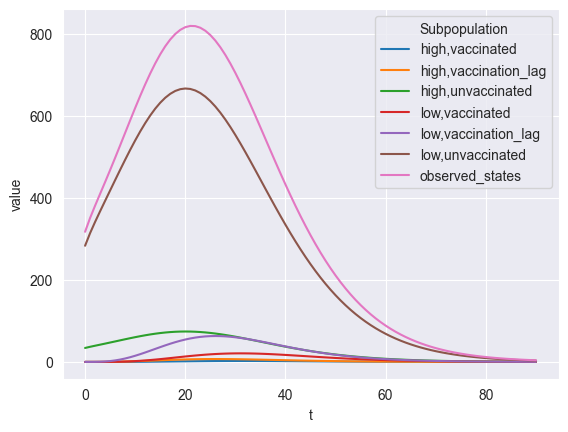

In [55]:
results_vaccination_unstacked = unstack_results_and_plot_hospitalised(results_vaccination)

In [56]:
display({'Total hospitalisations': results_vaccination.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_vaccination.loc[:,('observed_states','H')])})

{'Total hospitalisations': 5891.09994487683,
 'Peak hospitalisations': 818.5508078089962}

# 5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.

## 5.1 Setup class for running

In [57]:
class VaccinationLHSSimulation:

    def __init__(self, metapop_model, t, y0, fixed_parameter):
        self.metapop_model = metapop_model
        self.t = t
        self.y0 = y0
        self.fixed_parameter = fixed_parameter

    def run_sample(self, sample):
        parameters = vaccination_parameters_setup(**sample, other_parameters=self.fixed_parameter, metapop_model=self.metapop_model)
        self.metapop_model.pararmeters = parameters
        results = self.metapop_model.integrate(self.y0, self.t)
        focused_results = {'Total hospitalisations': results.loc[90,('observed_states','H_cumulative')],
                           'Peak hospitalisations': max(results.loc[:,('observed_states','H')])}
        results_and_sample_df = {**sample, **focused_results}
        return results_and_sample_df

In [58]:
vaccine_model_for_lhs = VaccinationLHSSimulation(metapop_model=metapop_model, t=t, y0=y, fixed_parameter=other_parameters)

## 5.2 Setup parameter ranges to sample from.

**Note** currently metacast only support latin hypercube sampling with uniform distributions.

In [59]:
parameter_samples_records = [
    {'parameter': 'nu_0', 'Lower Bound': prob_over_many_days_to_prob_on_a_day(0.8, v_day), 'Upper Bound': prob_over_many_days_to_prob_on_a_day(0.9999, v_day)},
    {'parameter': 'nu_1', 'Lower Bound': 1/28, 'Upper Bound': 1/14},
    {'parameter': 'l_v', 'Lower Bound': 0.7, 'Upper Bound': 0.95},
    {'parameter': 'h_v', 'Lower Bound': 0.7, 'Upper Bound': 0.95}
]
parameter_samples_df = pd.DataFrame.from_records(parameter_samples_records)
parameter_samples_df.set_index('parameter',inplace=True)
parameter_samples_df

,Lower Bound,Upper Bound
parameter,,
nu_0,0.017724,0.097275
nu_1,0.035714,0.071429
l_v,0.700000,0.950000
h_v,0.700000,0.950000


##  5.3 Run simulations with LHS

In [60]:
from metacast.sensitivity_analyses import lhs_prcc

In [64]:
results_and_sample_df, prccs = lhs_prcc(parameters_df=parameter_samples_df, sample_size=5, model_run_method=vaccine_model_for_lhs.run_sample, max_workers=1)

pydev debugger: Unable to find real location for: C:\Users\mdgru\AppData\Local\Temp\ipykernel_23196\2843739803.py


Simulating LH Sample:   0%|          | 0/5 [00:00<?, ?it/s]